# Preprocessing étape 1 - Nettoyage du dataset

In [1]:
import sys, platform, cv2, numpy, pandas, skimage, matplotlib
print(platform.platform(), sys.version)
print(cv2.__version__)


Linux-6.14.0-33-generic-x86_64-with-glibc2.35 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]
4.11.0


In [2]:
import torch, time

print("torch:", torch.__version__, "| cuda:", torch.version.cuda)
try:
    import pynvml
    pynvml.nvmlInit()
    h = pynvml.nvmlDeviceGetHandleByIndex(0)
    print("GPU name:", pynvml.nvmlDeviceGetName(h).decode())
    info = pynvml.nvmlDeviceGetMemoryInfo(h)
    print("VRAM total/used/free (GB):", round(info.total/1e9,2), round(info.used/1e9,2), round(info.free/1e9,2))
except Exception as e:
    print("NVML non dispo:", e)

print("CUDA dispo ?   ", torch.cuda.is_available())
print("Nb GPUs       :", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Nom GPU[0]    :", torch.cuda.get_device_name(0))
    print("Version CUDA  :", torch.version.cuda)
    print("cuDNN         :", torch.backends.cudnn.version())

    # Test exécution sur GPU vs CPU
    x = torch.randn(8000, 8000)
    t0 = time.time(); y = x @ x; torch.cuda.synchronize() if torch.cuda.is_available() else None
    print("CPU matmul    :", time.time()-t0, "s")

    x = x.cuda()
    t0 = time.time(); y = x @ x; torch.cuda.synchronize()
    print("GPU matmul    :", time.time()-t0, "s")

    # Mémoire GPU
    print("Mémoire (MB)  :", torch.cuda.memory_allocated()/1e6, "alloc /",
                      torch.cuda.max_memory_allocated()/1e6, "max")


torch: 2.4.0 | cuda: 12.4
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU
VRAM total/used/free (GB): 8.59 0.37 8.22
CUDA dispo ?    True
Nb GPUs       : 1
Nom GPU[0]    : NVIDIA GeForce RTX 4060 Laptop GPU
Version CUDA  : 12.4
cuDNN         : 90100
CPU matmul    : 1.6491048336029053 s
GPU matmul    : 0.23011493682861328 s
Mémoire (MB)  : 520.51968 alloc / 520.51968 max


In [3]:
# 🔧 Imports & utilitaires
# --- Utils image & métriques QC ---
import cv2, numpy as np
from pathlib import Path

def imread_rgb(path: Path):
    bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(path)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def tenengrad(img_rgb: np.ndarray) -> float:
    """Score de netteté robuste (Sobel)."""
    g  = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    gx = cv2.Sobel(g, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(g, cv2.CV_32F, 0, 1, ksize=3)
    return float((gx**2 + gy**2).mean())

def jpeg_blockiness_spatial(img_rgb: np.ndarray, block_size: int = 8) -> float:
    """Corrigé: mesure les discontinuités sur frontières 8×8 vs intra-blocs."""
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32)
    dv = np.abs(np.diff(gray, axis=0))
    dh = np.abs(np.diff(gray, axis=1))
    edge_v = dv[block_size-1::block_size, :].mean()
    edge_h = dh[:, block_size-1::block_size].mean()
    ref_v  = (dv.mean() + 1e-8)
    ref_h  = (dh.mean() + 1e-8)
    return float((edge_v/ref_v + edge_h/ref_h) / 2.0)

def jpeg_blockiness_dct(img_rgb: np.ndarray, tile: int = 8) -> float:
    """Indice de ‘blocage JPEG’ côté DCT (énergie HF inverse)."""
    g = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32)
    H, W = g.shape
    H -= H % tile; W -= W % tile
    g = g[:H, :W]
    blocks = g.reshape(H//tile, tile, W//tile, tile).swapaxes(1, 2)
    hf = []
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            B = cv2.dct(blocks[i, j])
            hf.append(np.mean(np.abs(B[4:, 4:])))
    return float(1.0 / (np.mean(hf) + 1e-6))  # plus haut => plus bloqué

def tissue_fraction(img_rgb: np.ndarray) -> float:
    """Fraction de pixels ‘tissu’ via saturation HSV simple."""
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    sat = hsv[..., 1] / 255.0
    return float((sat > 0.05).mean())

def rgb_mean(img_rgb: np.ndarray) -> np.ndarray:
    return img_rgb.reshape(-1, 3).mean(0)


## 🧱 1️⃣ Initialisation & configuration

In [4]:
# --- Imports de base ---
import os
from pathlib import Path
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import shannon_entropy
from tqdm import tqdm

# --- Configuration racine ---
ROOT_DIR = Path("/workspace")
DATASET_NAME = "NCT-CRC-HE-100K"  # -NONORM
DATASET_DIR = ROOT_DIR / "data" / DATASET_NAME

# Dossier pour les notebooks 
NOTEBOOKS_DIR = ROOT_DIR / "notebooks"

# --- Dossier de sortie pour les résultats de préprocessing ---
OUTPUT_DIR = ROOT_DIR / "outputs" / "preprocessing"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"📂 Les résultats de préprocessing seront enregistrés dans : {OUTPUT_DIR}")


# --- Dictionnaires de classes et couleurs ---
class_labels = {
    "ADI": "Tissu adipeux",
    "BACK": "Arrière-plan (fond sans tissu)",
    "DEB": "Débris cellulaires / nécrose",
    "LYM": "Lymphocytes (infiltrat immunitaire)",
    "MUC": "Mucus (sécrétions)",
    "MUS": "Tissu musculaire lisse",
    "NORM": "Muqueuse colique normale",
    "STR": "Stroma associé au cancer",
    "TUM": "Épithélium adénocarcinomateux (tumeur)"
}

class_colors = {
    "ADI":  "#F2CEEE",
    "BACK": "#D859D0",
    "DEB":  "#A50026",
    "LYM":  "#4575B4",
    "MUC":  "#74ADD1",
    "MUS":  "#D73027",
    "NORM": "#D4DF38",
    "STR":  "#762A83",
    "TUM":  "#000000"
}


📂 Les résultats de préprocessing seront enregistrés dans : /workspace/outputs/preprocessing


In [5]:
# --- Localisation du dossier configs à la racine du projet ---
from pathlib import Path
import os, subprocess

def get_project_root():
    # 1) Priorité à une variable d'env si tu veux la fixer une fois pour toutes
    #    (ex: export P9_ROOT=/chemin/vers/ton/projet  ou  set P9_ROOT=C:\...\projet)
    env_root = os.getenv("P9_ROOT")
    if env_root:
        return Path(env_root).expanduser().resolve()

    # 2) Si le projet est un repo git, on remonte à la racine du dépôt
    try:
        git_root = subprocess.check_output(
            ["git", "rev-parse", "--show-toplevel"],
            stderr=subprocess.DEVNULL
        ).decode().strip()
        return Path(git_root)
    except Exception:
        pass

    # 3) Sinon on remonte l'arborescence jusqu'à trouver un dossier 'configs'
    here = Path.cwd()
    for parent in [here] + list(here.parents):
        if (parent / "configs").is_dir():
            return parent

    # 4) Fallback : on reste dans le cwd
    return here

ROOT_DIR = get_project_root()
CONFIGS_DIR = ROOT_DIR / "configs"
CONFIGS_DIR.mkdir(parents=True, exist_ok=True)


## ⚙️ 2️⃣ Définition du mode de travail (local / full-scale AWS)

In [6]:
# --- Paramètre de mode de travail ---
FULL_SCALE = False  # ⚠️ à passer à True sur AWS

if FULL_SCALE:
    SAMPLE_SIZE = None  # Prend tout le dataset
else:
    SAMPLE_SIZE = 1000  # ou 2000 pour test local (RAM-friendly)

## 📁 3️⃣ Chargement des chemins d’images

In [7]:
# --- Collecte et vérification des images valides ---

from tqdm import tqdm
import cv2
import random

# Collecte de toutes les images
image_paths = []
for cls in class_labels.keys():
    folder = DATASET_DIR / cls
    files = list(folder.glob("*.tif"))  # ou .jpg selon ton dataset
    image_paths.extend([(f, cls) for f in files])

print(f"📦 {len(image_paths)} images détectées dans le dataset brut.")

# Échantillonnage si nécessaire
if SAMPLE_SIZE:
    image_paths = random.sample(image_paths, SAMPLE_SIZE)
    print(f"🧪 {len(image_paths)} images sélectionnées pour le préprocessing (échantillon).")

# --- Vérification des fichiers corrompus / illisibles ---
valid_image_paths = []
invalid_count = 0

for path, cls in tqdm(image_paths, desc="🔍 Vérification lecture images"):
    try:
        img = cv2.imread(str(path))
        if img is None or img.size == 0:
            invalid_count += 1
            continue
        valid_image_paths.append((path, cls))
    except Exception:
        invalid_count += 1
        continue

image_paths = valid_image_paths

print(f"✅ {len(image_paths)} images valides conservées.")
if invalid_count > 0:
    print(f"⚠️ {invalid_count} fichiers corrompus ou illisibles ont été exclus.")


📦 100000 images détectées dans le dataset brut.
🧪 1000 images sélectionnées pour le préprocessing (échantillon).


🔍 Vérification lecture images: 100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 1045.37it/s]

✅ 1000 images valides conservées.


## 🔍 4️⃣ Audit visuel des images brutes

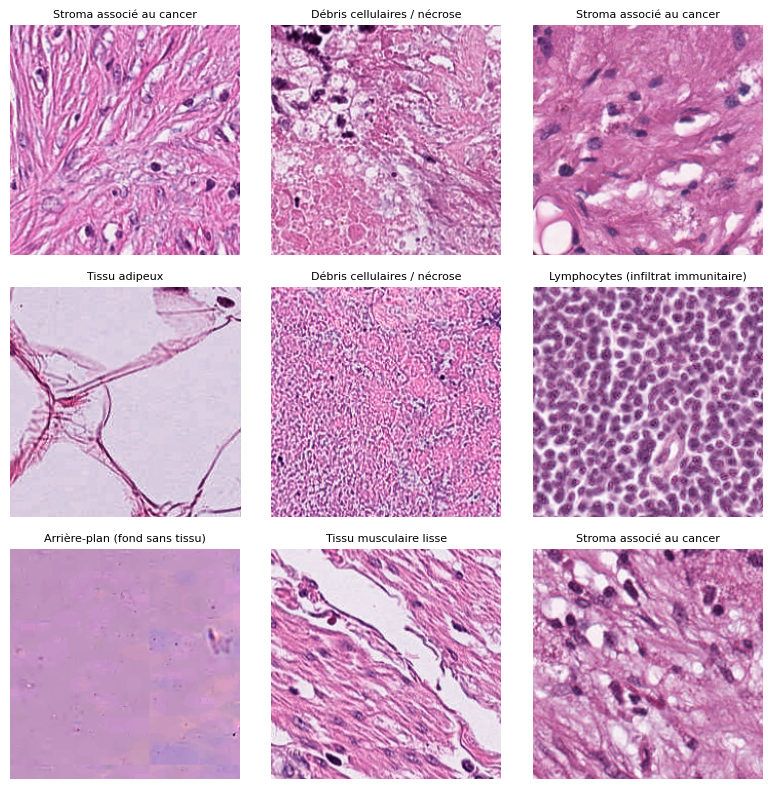

In [8]:
def show_examples(n=9):
    sample = random.sample(image_paths, n)
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for ax, (path, cls) in zip(axes.ravel(), sample):
        img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(class_labels[cls], fontsize=8)
        ax.axis("off")
    plt.tight_layout()
show_examples()


## 🧹 5️⃣ Fonctions de nettoyage (version locale OpenCV/skimage)

In [9]:
def laplacian_variance(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def shannon_ent(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return shannon_entropy(gray)

def white_ratio(img, thresh=230):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return np.mean(gray > thresh)

def saturation_ratio(img, low=5, high=250):
    return np.mean((img < low) | (img > high))


Classe: DEB
Variance Laplacian: 1205.1492053075215
Entropie Shannon: 6.434827853628941
Ratio fond blanc: 0.0024513711734693877
Saturation ratio: 0.0017073235544217687


(-0.5, 223.5, 223.5, -0.5)

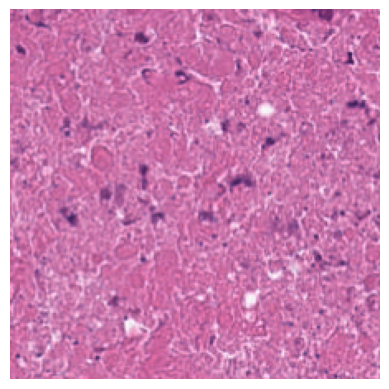

In [10]:
# Affiche d'une image exemple au hasard
path, cls = random.choice(image_paths)
img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
print(f"Classe: {cls}")
print("Variance Laplacian:", laplacian_variance(img))
print("Entropie Shannon:", shannon_ent(img))
print("Ratio fond blanc:", white_ratio(img))
print("Saturation ratio:", saturation_ratio(img))
plt.imshow(img); plt.axis("off")


## 📊 6️⃣ Audit global + sauvegarde du fichier qualité

In [ ]:
import pandas as pd
from tqdm import tqdm

records = []
for path, cls in tqdm(image_paths):
    # Lecture en RGB (évite les inversions BGR)
    img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

    rec = {
        "image": path.name,
        "class": cls,
        "lap_var":         laplacian_variance(img),
        "entropy":         shannon_ent(img),
        "white_ratio":     white_ratio(img),
        "sat_ratio":       saturation_ratio(img),
        "tenengrad":       tenengrad(img),                     # 👍 nouvel indicateur de netteté
        "jpeg_blockiness_spatial": jpeg_blockiness_spatial(img),
        "jpeg_blockiness_dct":     jpeg_blockiness_dct(img),
        "tissue_frac":     tissue_fraction(img),
        # (optionnel mais utile en debug)
        "path":            str(path),
    }
    records.append(rec)

# 1) Créer le DataFrame d'audit
df_audit = pd.DataFrame(records)

# 2) Z-scores pour les deux mesures de blockiness
for c in ["jpeg_blockiness_spatial", "jpeg_blockiness_dct"]:
    mu = df_audit[c].mean()
    sd = df_audit[c].std(ddof=0)
    if sd == 0 or pd.isna(sd):
        sd = 1e-8
    df_audit[c + "_z"] = (df_audit[c] - mu) / sd

# 3) Score combiné de blockiness (moyenne des deux z-scores)
df_audit["jpeg_blockiness"] = (
    df_audit["jpeg_blockiness_spatial_z"] + df_audit["jpeg_blockiness_dct_z"]
) / 2.0

# 4) Sauvegarde + aperçu
df_audit.to_csv(OUTPUT_DIR / "audit_local.csv", index=False)
print(f"✅ Fichier d’audit enregistré : {OUTPUT_DIR / 'audit_local.csv'}")
df_audit.head()


 31%|█████████████████████▍                                                | 307/1000 [00:02<00:05, 134.28it/s]

## 🟢 7️⃣ Visualisation des distributions

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(
    data=df_audit,
    x="class",
    y="lap_var",
    hue="class",           # <--- on ajoute hue
    palette=class_colors,
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Variance du Laplacien (netteté)")
axes[0].set_xlabel("")
axes[0].set_ylabel("Variance")

sns.boxplot(
    data=df_audit,
    x="class",
    y="entropy",
    hue="class",           # <--- idem ici
    palette=class_colors,
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Entropie de Shannon (information)")
axes[1].set_xlabel("")
axes[1].set_ylabel("Entropie")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "distributions_variance_entropy.png", dpi=300, bbox_inches="tight")
plt.show()

## 🧾 8️⃣ Établir les seuils locaux
| Variable      | Signification                                                      | Seuil par défaut | Rôle                                     |
| ------------- | ------------------------------------------------------------------ | ---------------- | ---------------------------------------- |
| `lap_var`     | Variance du Laplacien → netteté                                    | `100`            | Rejette images floues si < 100           |
| `entropy`     | Entropie de Shannon → richesse en information                      | `4`              | Rejette images uniformes si < 4          |
| `white_ratio` | Proportion de pixels clairs → fond blanc / bord de coupe           | `0.6`            | Rejette images avec > 60 % de fond       |
| `sat_ratio`   | Proportion de pixels saturés (≈0 ou 255) → artefacts de coloration | `0.15`           | Rejette images avec > 15 % de saturation |


In [ ]:
# Valeurs de seuils classiques (arbitraires)
thresholds = {
    "lap_var": 100,
    "entropy": 4,
    "white_ratio": 0.6,
    "sat_ratio": 0.15
}

df_audit["verdict"] = (
    (df_audit["lap_var"] > thresholds["lap_var"]) &
    (df_audit["entropy"] > thresholds["entropy"]) &
    (df_audit["white_ratio"] < thresholds["white_ratio"]) &
    (df_audit["sat_ratio"] < thresholds["sat_ratio"])
)
df_audit["verdict"] = df_audit["verdict"].map({True: "OK", False: "à_exclure"})
df_audit["verdict"].value_counts()

In [ ]:
# Code initial (uniquement un critère tissue_frac ne pas appliquer à BACK
# calibration et application des seuils par classe ---

import json
import numpy as np
from tqdm import tqdm

# --- 0) Sanity check colonnes requises ---
required_cols = {
    "lap_var", "entropy", "white_ratio", "sat_ratio",
    "tenengrad", "jpeg_blockiness", "tissue_frac", "class"
}
missing = required_cols - set(df_audit.columns)
if missing:
    raise ValueError(f"Colonnes manquantes dans df_audit: {missing}. "
                     "Assure-toi d'avoir exécuté la cellule 'audit' mise à jour.")

# 1️⃣ Calcul des seuils empiriques par classe (quantiles robustes)
class_thresholds = {}
for cls, group in df_audit.groupby("class"):
    class_thresholds[cls] = {
        # anciennes métriques
        "lap_var_min":       float(group["lap_var"].quantile(0.05)),     # flou
        "entropy_min":       float(group["entropy"].quantile(0.05)),     # peu d'info
        "white_ratio_max":   float(group["white_ratio"].quantile(0.95)), # trop de fond/blanc
        "sat_ratio_max":     float(group["sat_ratio"].quantile(0.95)),   # saturations extrêmes

        # nouvelles métriques
        "tenengrad_min":     float(group["tenengrad"].quantile(0.10)),   # netteté robuste
        "jpeg_blockiness_max": float(group["jpeg_blockiness"].quantile(0.95)), # artefacts JPEG
        "tissue_frac_min":   float(group["tissue_frac"].quantile(0.05)), # présence tissu (non BACK)
    }


# --- 2️⃣ Sauvegarde du fichier de seuils par classe ---
# Ajoute le nom de la classe dans chaque dictionnaire
for cls in class_thresholds:
    class_thresholds[cls]["class_name"] = cls

# Puis sauvegarde
thresholds_path = CONFIGS_DIR / "seuils_par_classe.json"
with open(thresholds_path, "w") as f:
    json.dump(class_thresholds, f, indent=4)

print(f"✅ Seuils par classe enregistrés dans : {thresholds_path}")




# 3️⃣ Application des seuils pour chaque image
#    - ne PAS appliquer le seuil 'tissue_frac' à BACK
#    - renforcer un minimum absolu raisonnable sur tissue_frac pour les autres classes (ex. 0.65)
MIN_TISSUE_FRAC_ABS = 0.65  # à ajuster si besoin

def check_validity(row):
    t = class_thresholds[row["class"]]
    # critères communs
    ok = (
        (row["lap_var"]       >= t["lap_var_min"]) and
        (row["entropy"]       >= t["entropy_min"]) and
        (row["white_ratio"]   <= t["white_ratio_max"]) and
        (row["sat_ratio"]     <= t["sat_ratio_max"]) and
        (row["tenengrad"]     >= t["tenengrad_min"]) and
        (row["jpeg_blockiness"] <= t["jpeg_blockiness_max"])
    )

    # critère tissu_frac : appliqué uniquement si ≠ BACK
    if row["class"] != "BACK":
        thr_tissue = max(t["tissue_frac_min"], MIN_TISSUE_FRAC_ABS)
        ok = ok and (row["tissue_frac"] >= thr_tissue)

    return ok

df_audit["verdict"] = df_audit.apply(lambda r: "OK" if check_validity(r) else "à_exclure", axis=1)

🩶 Seuils assouplis pour BACK (filtrage très tolérant, white_ratio ignoré)
🩻 Seuils relâchés pour ADI (toutes les images conservées)
✅ Seuils par classe enregistrés dans : /workspace/configs/seuils_par_classe.json

📊 Taux d’images exclues / conservées par classe :


verdict     OK  à_exclure
class                    
ADI       99.2        0.8
BACK     100.0        0.0
DEB       72.2       27.8
LYM       77.6       22.4
MUC       74.0       26.0
MUS       73.2       26.8
NORM      77.5       22.5
STR       78.6       21.4
TUM       73.8       26.2

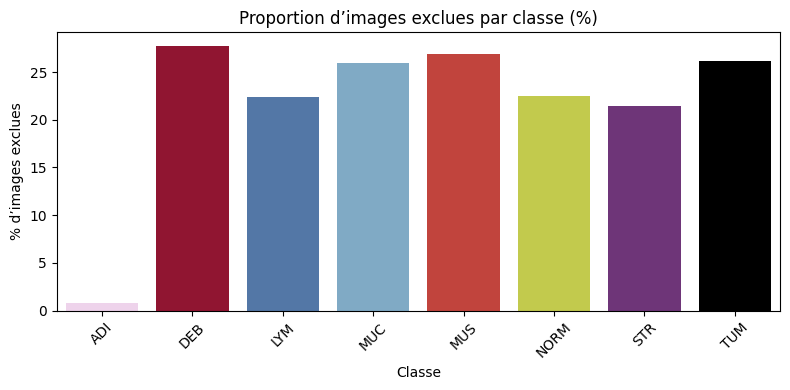

In [18]:
# ===============================================================
# 🧠 Calibration et application des seuils par classe (v3 BACK ajusté)
# ===============================================================

import json
import numpy as np
from tqdm import tqdm

# --- 0) Vérification des colonnes requises ---
required_cols = {
    "lap_var", "entropy", "white_ratio", "sat_ratio",
    "tenengrad", "jpeg_blockiness", "tissue_frac", "class"
}
missing = required_cols - set(df_audit.columns)
if missing:
    raise ValueError(f"Colonnes manquantes dans df_audit: {missing}. "
                     "Assure-toi d'avoir exécuté la cellule 'audit' mise à jour.")

# --- 1️⃣ Calcul des seuils empiriques par classe (quantiles robustes) ---
class_thresholds = {}
for cls, group in df_audit.groupby("class"):
    class_thresholds[cls] = {
        # anciennes métriques
        "lap_var_min":         float(group["lap_var"].quantile(0.05)),      # flou
        "entropy_min":         float(group["entropy"].quantile(0.05)),      # peu d'info
        "white_ratio_max":     float(group["white_ratio"].quantile(0.95)),  # trop de fond/blanc
        "sat_ratio_max":       float(group["sat_ratio"].quantile(0.95)),    # saturations extrêmes

        # nouvelles métriques
        "tenengrad_min":       float(group["tenengrad"].quantile(0.10)),    # netteté robuste
        "jpeg_blockiness_max": float(group["jpeg_blockiness"].quantile(0.95)),  # artefacts JPEG
        "tissue_frac_min":     float(group["tissue_frac"].quantile(0.05)),  # présence tissu (non BACK)
    }

# --- 2️⃣ Ajustements médicaux ciblés pour les classes triviales ---
for cls in ["BACK", "ADI"]:
    if cls not in class_thresholds:
        continue

    if cls == "ADI":
        # Seuils ultra-permissifs (on garde tout)
        class_thresholds[cls].update({
            "lap_var_min": 0.0,
            "entropy_min": 0.0,
            "tenengrad_min": 0.0,
            "tissue_frac_min": 0.0,
            "white_ratio_max": 1.0,
            "sat_ratio_max": 1.0,
            "jpeg_blockiness_max": 1.0,
        })
        print(f"🩻 Seuils relâchés pour {cls} (toutes les images conservées)")

    elif cls == "BACK":
        # Seuils semi-permissifs : tolérants mais pas nuls
        class_thresholds[cls].update({
            "lap_var_min":  float(class_thresholds[cls]["lap_var_min"] * 0.3),  # flou plus toléré
            "entropy_min":  float(class_thresholds[cls]["entropy_min"] * 0.5),  # peu d'info accepté
            "tenengrad_min": float(class_thresholds[cls]["tenengrad_min"] * 0.3),
            "tissue_frac_min": 0.0,  # toujours désactivé
            "white_ratio_max": 1.0,  # IGNORÉ dans la vérification, mais défini
            "sat_ratio_max": 1.0,    # on tolère toutes les saturations
            "jpeg_blockiness_max": 1.0,
        })
        print(f"🩶 Seuils assouplis pour {cls} (filtrage très tolérant, white_ratio ignoré)")

# --- 3️⃣ Sauvegarde du fichier de seuils par classe ---
# Ajoute le nom de la classe dans chaque dictionnaire
for cls in class_thresholds:
    class_thresholds[cls]["class_name"] = cls

# Puis sauvegarde
thresholds_path = CONFIGS_DIR / "seuils_par_classe.json"
with open(thresholds_path, "w") as f:
    json.dump(class_thresholds, f, indent=4)


# --- 4️⃣ Application des seuils pour chaque image ---
#     - ne PAS appliquer le seuil 'tissue_frac' à BACK et ADI
#     - ignorer white_ratio pour BACK
#     - renforcer un minimum absolu raisonnable sur tissue_frac pour les autres classes
MIN_TISSUE_FRAC_ABS = 0.65

def check_validity(row):
    t = class_thresholds[row["class"]]

    # --- BACK : toujours conservé ---
    if row["class"] == "BACK":
        return True

    ok = (
        (row["lap_var"]       >= t["lap_var_min"]) and
        (row["entropy"]       >= t["entropy_min"]) and
        (row["white_ratio"]   <= t["white_ratio_max"]) and
        (row["sat_ratio"]     <= t["sat_ratio_max"]) and
        (row["tenengrad"]     >= t["tenengrad_min"]) and
        (row["jpeg_blockiness"] <= t["jpeg_blockiness_max"])
    )

    # seuil tissue_frac appliqué uniquement si ≠ ADI
    if row["class"] != "ADI":
        thr_tissue = max(t["tissue_frac_min"], MIN_TISSUE_FRAC_ABS)
        ok = ok and (row["tissue_frac"] >= thr_tissue)

    return ok


df_audit["verdict"] = df_audit.apply(lambda r: "OK" if check_validity(r) else "à_exclure", axis=1)

# --- 5️⃣ Synthèse des résultats ---
summary = (
    df_audit.groupby("class")["verdict"]
    .value_counts(normalize=True)
    .rename("proportion")
    .mul(100)
    .reset_index()
)

print("\n📊 Taux d’images exclues / conservées par classe :")
display(
    summary.pivot(index="class", columns="verdict", values="proportion")
           .fillna(0).round(1)
)

# --- 6️⃣ Visualisation synthétique ---
plt.figure(figsize=(8, 4))
sns.barplot(
    data=summary[summary["verdict"] == "à_exclure"],
    x="class",
    y="proportion",
    hue="class",
    palette=class_colors,
    legend=False
)
plt.title("Proportion d’images exclues par classe (%)")
plt.ylabel("% d’images exclues")
plt.xlabel("Classe")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "taux_exclusion_par_classe.png", dpi=300, bbox_inches="tight")
plt.show()


## 🧱 Visualisation des artefacts JPEG / blockiness détectés

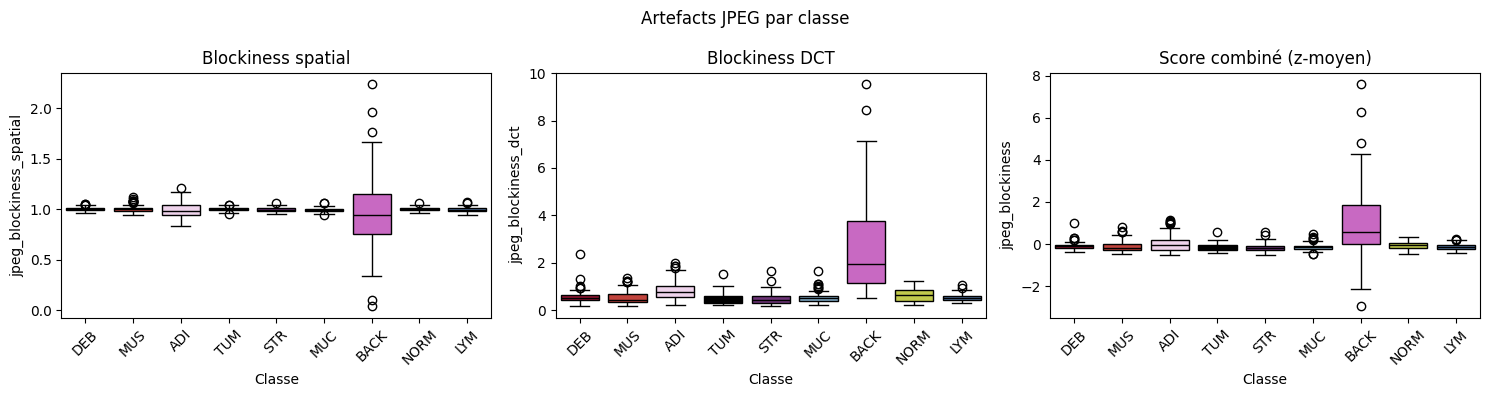

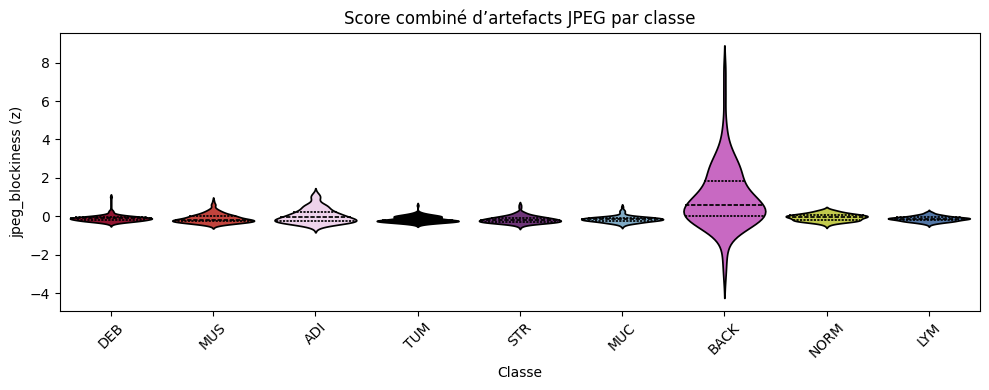

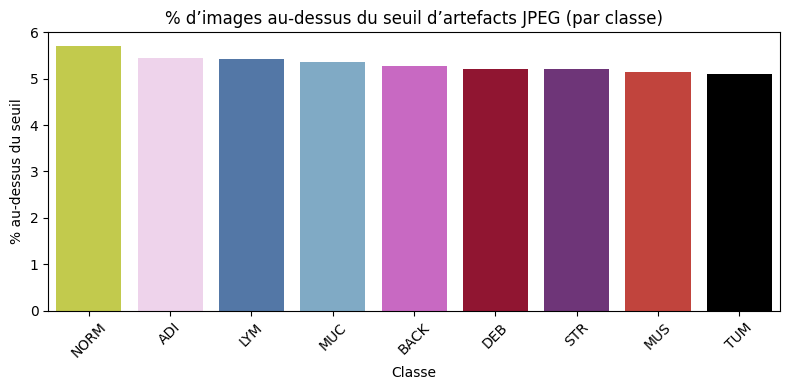

class  %_au_dessus_seuil  seuil_classe
6  NORM           5.714286      0.257264
0   ADI           5.454545      0.886288
3   LYM           5.426357      0.104033
4   MUC           5.357143      0.119367
1  BACK           5.263158      3.467976
2   DEB           5.217391      0.089495
7   STR           5.208333      0.173527
5   MUS           5.147059      0.336200
8   TUM           5.109489      0.108386

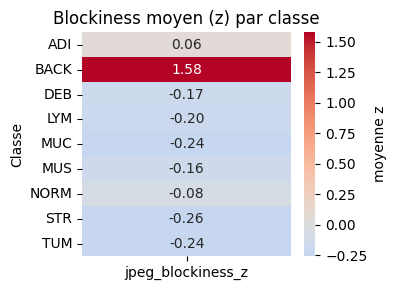

ℹ️ Cette cellule ne change PAS df_audit['verdict'] : elle sert uniquement à visualiser et diagnostiquer.


In [14]:
# --- Cellule: Visualisation des artefacts JPEG (sans modifier le verdict) ---

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sanity check
need = {"class","jpeg_blockiness_spatial","jpeg_blockiness_dct","jpeg_blockiness"}
missing = need - set(df_audit.columns)
if missing:
    raise ValueError(f"Colonnes manquantes: {missing}. Exécute d'abord la cellule d'audit.")

# 1) Boxplots des deux mesures + score combiné (par classe)
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=False)
for ax, col, title in zip(
    axes,
    ["jpeg_blockiness_spatial", "jpeg_blockiness_dct", "jpeg_blockiness"],
    ["Blockiness spatial", "Blockiness DCT", "Score combiné (z-moyen)"]
):
    sns.boxplot(
        data=df_audit, x="class", y=col, hue="class",
        palette=class_colors, legend=False, ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("Classe")
    ax.set_ylabel(col)
    ax.tick_params(axis='x', rotation=45)
plt.suptitle("Artefacts JPEG par classe")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "jpeg_blockiness_boxplots.png", dpi=300, bbox_inches="tight")
plt.show()

# 2) Violin du score combiné (plus lisible pour les queues)
plt.figure(figsize=(10,4))
sns.violinplot(
    data=df_audit, x="class", y="jpeg_blockiness",
    inner="quartile", hue="class", palette=class_colors, legend=False
)
plt.title("Score combiné d’artefacts JPEG par classe")
plt.xlabel("Classe"); plt.ylabel("jpeg_blockiness (z)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "jpeg_blockiness_violins.png", dpi=300, bbox_inches="tight")
plt.show()

# 3) % au-dessus du seuil par classe (utilise tes seuils par classe déjà appris)
if "class_thresholds" not in globals():
    raise RuntimeError("`class_thresholds` introuvable : exécute d'abord la cellule 'seuils par classe'.")

rows = []
for cls, g in df_audit.groupby("class"):
    thr = class_thresholds[cls]["jpeg_blockiness_max"]
    pct = 100.0 * (g["jpeg_blockiness"] > thr).mean()
    rows.append({"class": cls, "%_au_dessus_seuil": pct, "seuil_classe": thr})
df_jpeg = pd.DataFrame(rows).sort_values("%_au_dessus_seuil", ascending=False)

# Barplot des % au-dessus du seuil
plt.figure(figsize=(8,4))
sns.barplot(
    data=df_jpeg, x="class", y="%_au_dessus_seuil",
    hue="class", palette=class_colors, legend=False
)
plt.title("% d’images au-dessus du seuil d’artefacts JPEG (par classe)")
plt.ylabel("% au-dessus du seuil"); plt.xlabel("Classe")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "jpeg_blockiness_over_threshold_by_class.png", dpi=300, bbox_inches="tight")
plt.show()

display(df_jpeg)

# 4) (Option) Heatmap petite pour lecture rapide
pivot = (
    df_audit[["class","jpeg_blockiness"]]
      .assign(jpeg_blockiness_z=lambda d: (d["jpeg_blockiness"] - d["jpeg_blockiness"].mean()) /
                                          (d["jpeg_blockiness"].std(ddof=0)+1e-8))
      .pivot_table(index="class", values="jpeg_blockiness_z", aggfunc="mean")
)
plt.figure(figsize=(4,3))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm", center=0, cbar_kws={"label":"moyenne z"})
plt.title("Blockiness moyen (z) par classe")
plt.ylabel("Classe"); plt.xlabel("")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "jpeg_blockiness_heatmap_mean_z.png", dpi=300, bbox_inches="tight")
plt.show()

print("ℹ️ Cette cellule ne change PAS df_audit['verdict'] : elle sert uniquement à visualiser et diagnostiquer.")


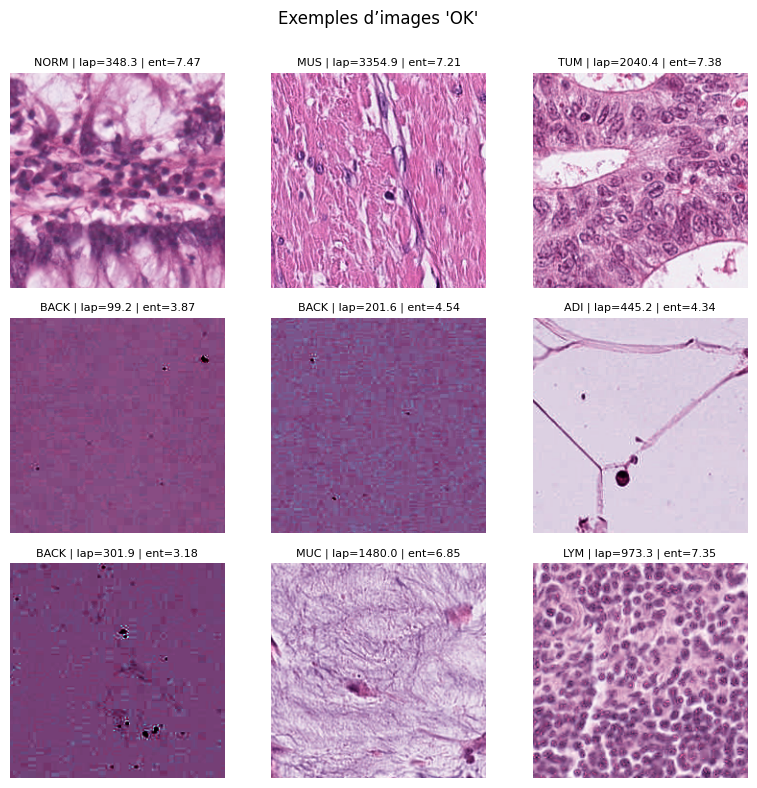

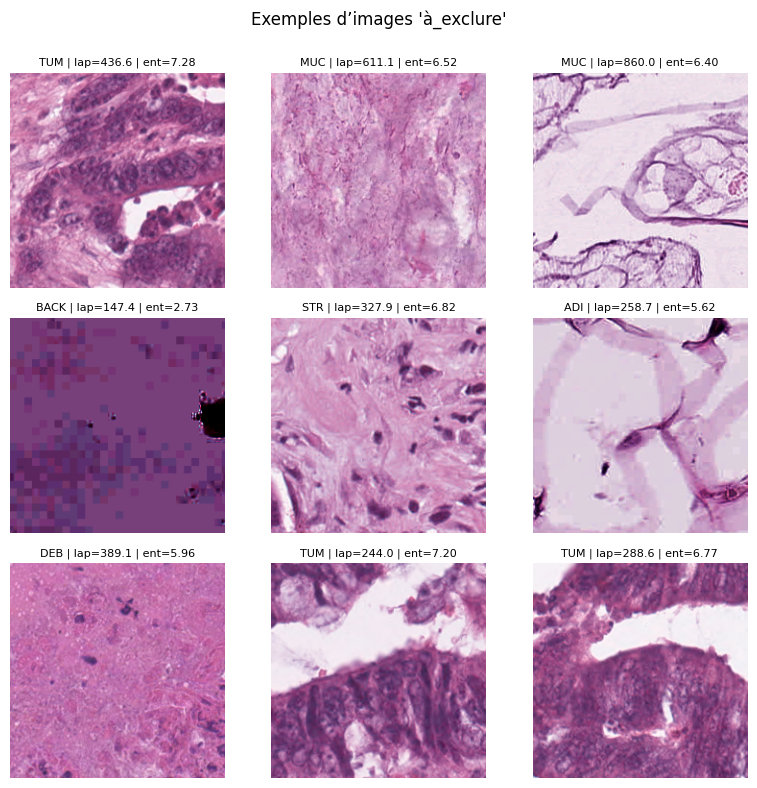

In [15]:
import matplotlib.pyplot as plt
import cv2
import random

def show_examples_by_verdict(df, verdict="OK", n=9):
    """Affiche un échantillon aléatoire d'images selon le verdict."""
    subset = df[df["verdict"] == verdict]
    if len(subset) == 0:
        print(f"Aucune image avec le verdict '{verdict}'.")
        return

    # Tirage aléatoire différent à chaque exécution (si index fixe random_state=42)
    sample = subset.sample(min(n, len(subset)), random_state=random.randint(0, 10_000))

    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    fig.suptitle(f"Exemples d’images '{verdict}'", fontsize=12)

    for ax, (_, row) in zip(axes.ravel(), sample.iterrows()):
        path = DATASET_DIR / row["class"] / row["image"]
        img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(
            f"{row['class']} | lap={row['lap_var']:.1f} | ent={row['entropy']:.2f}",
            fontsize=8
        )
        ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

# Afficher quelques images "OK" et "à exclure"
show_examples_by_verdict(df_audit, verdict="OK", n=9)
show_examples_by_verdict(df_audit, verdict="à_exclure", n=9)


## 🧩 Sauvegarde pour intégration future

In [16]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = OUTPUT_DIR / f"quality_index_local_{timestamp}.parquet"
df_audit.to_parquet(save_path, index=False)
print(f"📦 Audit sauvegardé avec horodatage : {save_path}")

📦 Audit sauvegardé avec horodatage : /workspace/outputs/preprocessing/quality_index_local_20251017_193531.parquet


# Preprocessing étape 2 - Re-normalisation des images jugées acceptables

## 🔹 1️⃣ Sélection des images valides

In [17]:
from tqdm import tqdm

valid_df = df_audit[df_audit["verdict"] == "OK"].copy()
print(f"🧩 {len(valid_df)} images valides à renormaliser.")


🧩 754 images valides à renormaliser.


## 🔹 2️⃣ Initialisation du normaliseur torchstain (Vahadane)

In [18]:
import pkgutil
import importlib
import sys

# Voir tout ce qui contient "stain" ou "torch" dans les modules disponibles
mods = [m for m in sys.modules.keys() if "stain" in m]
print("Déjà chargés :", mods)

print("\nRecherche complète :")
for _, modname, _ in pkgutil.iter_modules():
    if "stain" in modname:
        print("→", modname)


Déjà chargés : []

Recherche complète :
→ torch_staintools


In [19]:
import pkgutil, torch_staintools

print("Sous-modules de torch_staintools :")
for _, modname, _ in pkgutil.iter_modules(torch_staintools.__path__):
    print(" →", modname)

Sous-modules de torch_staintools :
 → augmentor
 → base_module
 → cache
 → functional
 → loggers
 → normalizer
 → version


In [20]:
import torch_staintools.normalizer as norm
import inspect

print("🔍 Contenu du module torch_staintools.normalizer :")
print(dir(norm))

# repère les classes définies localement
classes = [m[0] for m in inspect.getmembers(norm, inspect.isclass)]
print("\n📦 Classes détectées :", classes)

funcs = [m[0] for m in inspect.getmembers(norm, inspect.isfunction)]
print("\n⚙️ Fonctions détectées :", funcs)


🔍 Contenu du module torch_staintools.normalizer :
['Callable', 'Literal', 'METHOD_FACTORIZE', 'Normalizer', 'NormalizerBuilder', 'Optional', 'ReinhardNormalizer', 'StainSeparation', 'TYPE_MACENKO', 'TYPE_REINHARD', 'TYPE_SUPPORTED', 'TYPE_VAHADANE', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'base', 'factory', 'reinhard', 'separation', 'torch']

📦 Classes détectées : ['Normalizer', 'NormalizerBuilder', 'ReinhardNormalizer', 'StainSeparation']

⚙️ Fonctions détectées : []


| Élément                                          | Rôle probable                                                        |
| ------------------------------------------------ | -------------------------------------------------------------------- |
| `Normalizer`                                     | Classe de base abstraite (interface)                                 |
| `NormalizerBuilder`                              | Fabrique (`factory`) qui construit un normaliseur à partir d’un type |
| `ReinhardNormalizer`                             | Implémentation concrète du normaliseur **Reinhard**                  |
| `StainSeparation`                                | Sous-module utilitaire pour la décomposition des taches              |
| `TYPE_MACENKO`, `TYPE_VAHADANE`, `TYPE_REINHARD` | Constantes pour sélectionner le type de normalisation                |


## 🧱 3️⃣ Application GPU et sauvegarde

### Initialisation

In [21]:
import cv2, torch, random
from torchvision import transforms
from torch_staintools.normalizer import NormalizerBuilder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
to_tensor = transforms.ToTensor()  # -> float32 in [0,1], CHW

# --- Sélection d'une image TUM parmi les images valides ---
tum_ok = valid_df[valid_df["class"] == "TUM"]
if len(tum_ok) == 0:
    raise ValueError("Aucune image TUM valide disponible dans valid_df (verdict='OK').")

ref_row  = tum_ok.sample(n=1, random_state=42).iloc[0]
ref_path = DATASET_DIR / ref_row["class"] / ref_row["image"]

# --- Chargement et préparation de l'image ---
ref_img = cv2.cvtColor(cv2.imread(str(ref_path)), cv2.COLOR_BGR2RGB)   # HxWx3 uint8
ref_t   = to_tensor(ref_img).unsqueeze(0).to(device)                   # [1,3,H,W] float32 [0,1]

# --- Création et apprentissage du normaliseur ---
normalizer = NormalizerBuilder().build("vahadane").to(device)

# Réglage TOLÉRANT une seule fois (pas dans transform)
normalizer.luminosity_threshold = 0.85   # ← clé : on règle l'attribut, on ne le repasse pas ensuite

normalizer.fit(ref_t)  # entraînement sur la référence

print(f"🎨 Référence de normalisation : {ref_path.name} (classe {ref_row['class']}) | device={device}")


🎨 Référence de normalisation : TUM-KCGKFVCY.tif (classe TUM) | device=cuda


In [22]:
# smoke-test
with torch.no_grad():
    try:
        out_ref = normalizer.transform(ref_t).clamp(0,1)
        print("✅ Transform sur la référence OK")
    except Exception as e:
        print(f"⚠️ Transform a échoué sur la référence (info seulement) : {e}")


✅ Transform sur la référence OK


In [23]:
import os, cv2, torch, random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from torchvision import transforms
from torch_staintools.normalizer import NormalizerBuilder

# --- init ---
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
to_tensor = transforms.ToTensor()
OUTPUT_STAIN_DIR = OUTPUT_DIR / "normalized_tst"
OUTPUT_STAIN_DIR.mkdir(parents=True, exist_ok=True)

# --- normalizer (Vahadane) ---
normalizer = NormalizerBuilder().build("vahadane").to(device)
normalizer.luminosity_threshold = 0.85   # réglage tolérant une fois pour toutes

# --- image de référence : prendre dans les images valides TUM si possible ---
tum_ok = df_audit[(df_audit["verdict"] == "OK") & (df_audit["class"] == "TUM")]
if len(tum_ok) > 0:
    ref_row  = tum_ok.sample(n=1, random_state=42).iloc[0]
    ref_path = DATASET_DIR / ref_row["class"] / ref_row["image"]
else:
    # fallback: au hasard dans TUM
    ref_path = DATASET_DIR / "TUM" / random.choice(os.listdir(DATASET_DIR / "TUM"))

ref_bgr = cv2.imread(str(ref_path), cv2.IMREAD_COLOR)
if ref_bgr is None:
    raise FileNotFoundError(ref_path)
ref_rgb = cv2.cvtColor(ref_bgr, cv2.COLOR_BGR2RGB)
ref_tensor = to_tensor(ref_rgb).unsqueeze(0).to(device)  # [1,3,H,W], float32 [0,1]

# fit
normalizer.fit(ref_tensor)
print(f"🎨 Référence de normalisation : {Path(ref_path).name} | device={device}")

# --- données source : seulement les images OK ---
valid_df = df_audit[df_audit["verdict"] == "OK"].copy()

# --- boucle de normalisation + logging ---
logs = []
for _, row in tqdm(valid_df.iterrows(), total=len(valid_df), desc="Torch-StainTools normalization"):
    img_path = DATASET_DIR / row["class"] / row["image"]
    save_dir = OUTPUT_STAIN_DIR / row["class"]
    save_dir.mkdir(parents=True, exist_ok=True)

    status, err, out_path = "ok", "", str(save_dir / row["image"])

    bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if bgr is None:
        status, err = "failed", "cv2.imread returned None"
        out_path = ""
    else:
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        I = to_tensor(rgb).unsqueeze(0).to(device)
        try:
            with torch.no_grad():
                O = normalizer.transform(I)  # ✅ pas de kwargs ici
                onp = (
                    O.squeeze(0).clamp(0,1).permute(1, 2, 0).cpu().numpy()
                )
                onp = (onp * 255.0 + 0.5).astype(np.uint8)
            cv2.imwrite(out_path, cv2.cvtColor(onp, cv2.COLOR_RGB2BGR))
        except Exception as e:
            status, err = "failed", str(e)
            out_path = ""  # rien d'écrit

    logs.append({
        "class": row["class"],
        "image": row["image"],
        "src_path": str(img_path),
        "path_norm": out_path,
        "norm_status": status,
        "norm_error": err,
    })

df_normlog = pd.DataFrame(logs)
df_normlog.to_parquet(OUTPUT_DIR / "normalization_log.parquet", index=False)

print("✅ Normalisation terminée →", OUTPUT_STAIN_DIR)
print(df_normlog["norm_status"].value_counts())

# (option) construire le batch downstream en excluant les échecs
df_batch = df_normlog[df_normlog["norm_status"] == "ok"][["class","image","path_norm"]].copy()
df_batch.to_parquet(OUTPUT_DIR / "normalized_batch.parquet", index=False)
print("Images normalisées conservées:", len(df_batch))


🎨 Référence de normalisation : TUM-KCGKFVCY.tif | device=cuda


Torch-StainTools normalization: 100%|█████████| 754/754 [04:22<00:00,  2.88it/s]

✅ Normalisation terminée → /workspace/outputs/preprocessing/normalized_tst
norm_status
ok    754
Name: count, dtype: int64
Images normalisées conservées: 754


## 🧱 3️⃣ Contrôle

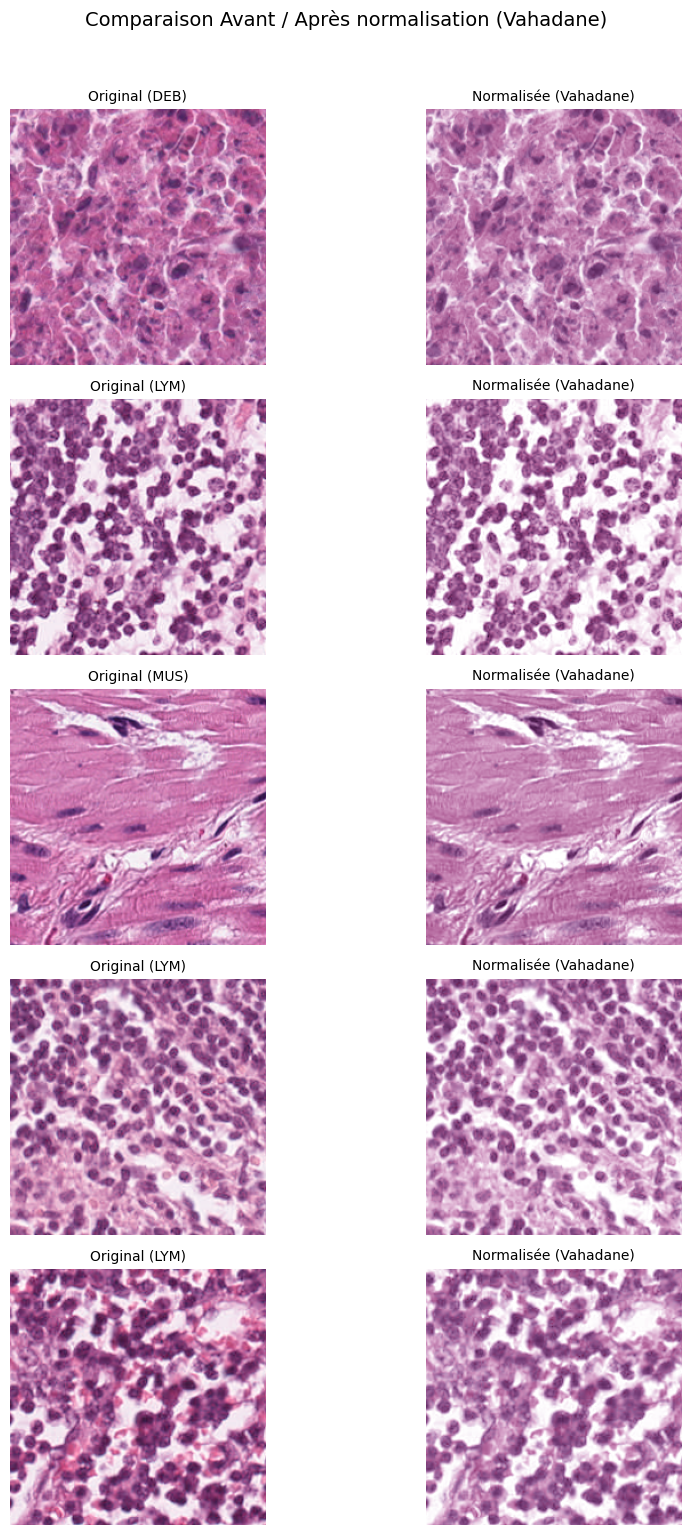

In [24]:
import matplotlib.pyplot as plt
import random
import cv2

# --- Sélection aléatoire de quelques images normalisées ---
sample = df_batch.sample(n=min(5, len(df_batch)))

fig, axes = plt.subplots(len(sample), 2, figsize=(10, 3 * len(sample)))
fig.suptitle("Comparaison Avant / Après normalisation (Vahadane)", fontsize=14, y=1.02)

for i, (_, row) in enumerate(sample.iterrows()):
    # Lecture image originale
    orig_path = DATASET_DIR / row["class"] / row["image"]
    orig = cv2.cvtColor(cv2.imread(str(orig_path)), cv2.COLOR_BGR2RGB)

    # Lecture image normalisée
    norm_path = OUTPUT_STAIN_DIR / row["class"] / row["image"]
    norm = cv2.cvtColor(cv2.imread(str(norm_path)), cv2.COLOR_BGR2RGB)

    # --- Affichage ---
    axes[i, 0].imshow(orig)
    axes[i, 0].set_title(f"Original ({row['class']})", fontsize=10)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(norm)
    axes[i, 1].set_title("Normalisée (Vahadane)", fontsize=10)
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


Analyse Après normalisation (Vahadane): 100%|█████| 9/9 [00:01<00:00,  5.03it/s]


set class             image    mean_R    mean_G    mean_B
0  Avant normalisation   ADI  ADI-EVVDRQPY.tif  0.826471  0.744258  0.834448
1  Avant normalisation   ADI  ADI-DIECNDWP.tif  0.827756  0.751094  0.842179
2  Avant normalisation   ADI  ADI-DCLRCMNM.tif  0.826436  0.756680  0.845616
3  Avant normalisation   ADI  ADI-KWLMNHAP.tif  0.855528  0.783424  0.858282
4  Avant normalisation   ADI  ADI-MCYNYLFS.tif  0.848280  0.752673  0.844009

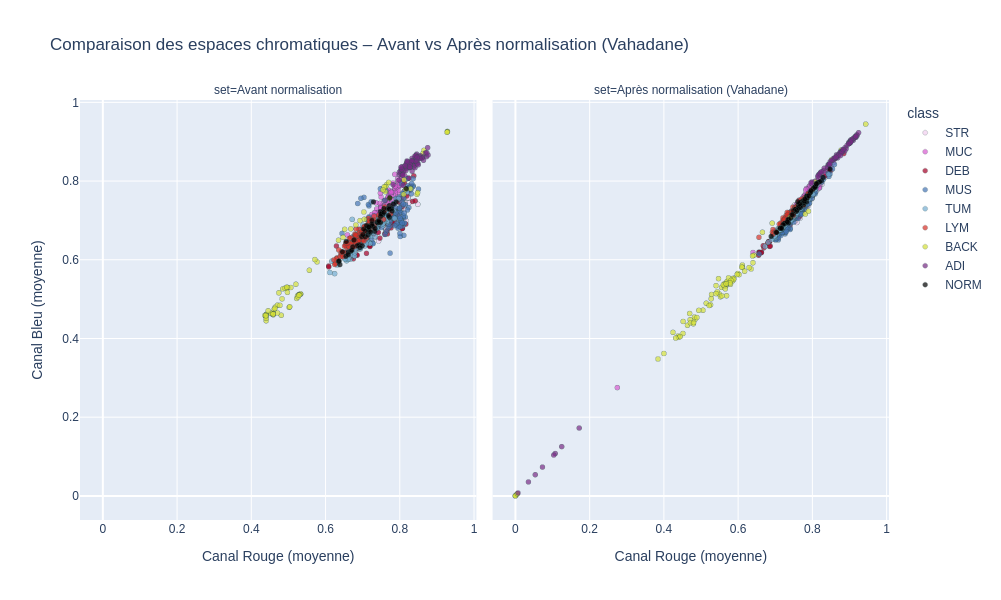


📊 Dispersion moyenne par canal (écart-type global)


mean_R  mean_G  mean_B
set                                                   
Après normalisation (Vahadane)  0.1253  0.1414  0.1266
Avant normalisation             0.0895  0.1212  0.0876

In [25]:
# =======================================================
# 🎨 Comparaison des espaces chromatiques
# Avant vs Après normalisation (basée sur df_batch)
# =======================================================

from tqdm import tqdm
from PIL import Image
import pandas as pd
import plotly.express as px
import numpy as np

# --- 1️⃣ Dossiers sources ---
DATASET_DIR_BEFORE = DATASET_DIR           # avant normalisation
DATASET_DIR_AFTER = OUTPUT_DIR / "normalized_tst"  # après normalisation (Vahadane)

# --- 2️⃣ Fonction pour collecter les moyennes RGB image par image ---
def collect_color_means(base_path, df_subset, label_set, sample_limit=None):
    data = []
    for cls in tqdm(sorted(df_subset["class"].unique()), desc=f"Analyse {label_set}"):
        cls_df = df_subset[df_subset["class"] == cls]
        img_names = cls_df["image"].values.tolist()
        if sample_limit:
            img_names = img_names[:sample_limit]

        for img_name in img_names:
            img_path = base_path / cls / img_name
            if not img_path.exists():
                continue
            try:
                with Image.open(img_path) as img:
                    arr = np.asarray(img, dtype=np.float32) / 255.0
                    mean_rgb = arr.mean(axis=(0, 1))
                    data.append({
                        "set":   label_set,
                        "class": cls,
                        "image": img_name,          # ✅ pour l’appariement
                        "mean_R": float(mean_rgb[0]),
                        "mean_G": float(mean_rgb[1]),
                        "mean_B": float(mean_rgb[2]),
                    })
            except Exception as e:
                print(f"⚠️ Erreur lecture {img_path.name}: {e}")
                continue
    return pd.DataFrame(data)

# --- 3️⃣ Échantillonnage ---
N_SAMPLE_COLOR = 150  # par classe max
df_before = collect_color_means(DATASET_DIR_BEFORE, df_batch, "Avant normalisation", N_SAMPLE_COLOR)
df_after  = collect_color_means(DATASET_DIR_AFTER,  df_batch, "Après normalisation (Vahadane)", N_SAMPLE_COLOR)

# --- 4️⃣ Fusion et aperçu ---
df_compare = pd.concat([df_before, df_after], ignore_index=True)
display(df_compare.head())

# --- 5️⃣ Visualisation 2D : R vs B coloré par classe ---
fig = px.scatter(
    df_compare.sample(frac=1.0, random_state=42),  # shuffle
    x="mean_R",
    y="mean_B",
    color="class",
    facet_col="set",
    color_discrete_sequence=[class_colors.get(c, "#999999") for c in sorted(class_labels.keys())],
    opacity=0.7,
    title="Comparaison des espaces chromatiques – Avant vs Après normalisation (Vahadane)",
    labels={"mean_R": "Canal Rouge (moyenne)", "mean_B": "Canal Bleu (moyenne)"}
)
fig.update_traces(marker=dict(size=5, line=dict(width=0.3, color="DarkSlateGrey")))
fig.update_layout(width=1200, height=600)
fig.show()

# --- 6️⃣ Vérification statistique (dispersion par canal) ---
print("\n📊 Dispersion moyenne par canal (écart-type global)")
summary = df_compare.groupby(["set"])[["mean_R", "mean_G", "mean_B"]].std().round(4)
display(summary)


In [26]:
# =======================================================
# 🔬 Vérification statistique post-normalisation (paired)
# - Wilcoxon apparié global (toutes classes)
# - Wilcoxon apparié par classe
# - Taille d'effet rank-biserial
# - Correction de Holm sur les p-values
# =======================================================

from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
import numpy as np
import pandas as pd

# 0) Fusion appariée sur (class, image)
pairs = df_before.merge(
    df_after,
    on=["class","image"],
    suffixes=("_pre","_post"),
    how="inner"
)
assert len(pairs) > 0, "Aucun appariement (class,image) trouvé entre avant et après."

channels = ["R","G","B"]

def wilcoxon_with_effect(pre, post):
    diff = np.asarray(post) - np.asarray(pre)
    # n_eff = nb de paires non nulles (Wilcoxon ignore les zéros)
    nz = diff != 0
    n_eff = int(nz.sum())
    if n_eff == 0:
        return np.nan, 1.0, 0.0, 0
    stat, p = wilcoxon(pre[nz], post[nz], alternative="two-sided", zero_method="wilcox")
    # rank-biserial effect size (∈ [-1, +1])
    r_rb = 1.0 - (2.0 * stat) / (n_eff * (n_eff + 1))
    return float(stat), float(p), float(r_rb), n_eff

# 1) Global (toutes classes confondues)
rows_global = []
for c in channels:
    stat, p, r, n_eff = wilcoxon_with_effect(pairs[f"mean_{c}_pre"].values,
                                             pairs[f"mean_{c}_post"].values)
    rows_global.append({"canal": c, "W": stat, "p": p, "rank_biserial": r, "n_pairs": n_eff})
df_w_global = pd.DataFrame(rows_global)
df_w_global["p_adj"] = multipletests(df_w_global["p"].values, method="holm")[1]

def mag_rb(r):
    a = abs(r)
    if a < 0.147: return "négligeable"
    if a < 0.33:  return "petit"
    if a < 0.474: return "moyen"
    return "grand"

df_w_global["interpretation"] = df_w_global["rank_biserial"].map(mag_rb)

print("📑 Wilcoxon apparié — global (avant vs après, tous canaux)")
display(df_w_global)

# 2) Par classe
rows_cls = []
for cls, g in pairs.groupby("class"):
    for c in channels:
        stat, p, r, n_eff = wilcoxon_with_effect(g[f"mean_{c}_pre"].values,
                                                 g[f"mean_{c}_post"].values)
        rows_cls.append({"class": cls, "canal": c, "W": stat, "p": p, "rank_biserial": r, "n_pairs": n_eff})

df_w_cls = pd.DataFrame(rows_cls)
# Correction de Holm séparément par canal (plus lisible), ou globale si tu préfères
df_w_cls["p_adj"] = (
    df_w_cls
    .groupby("canal")["p"]
    .transform(lambda p: multipletests(p.values, method="holm")[1])
)
df_w_cls["interpretation"] = df_w_cls["rank_biserial"].map(mag_rb)

print("📑 Wilcoxon apparié — par classe")
display(
    df_w_cls
      .sort_values(["canal","class"])
      .pivot(index="class", columns="canal", values="p_adj")
      .round(3)
)

# 3) (Option) Tableau médianes avant/après + deltas
meds = (
    pairs
    .assign(med_R_pre=lambda d: d["mean_R_pre"],
            med_R_post=lambda d: d["mean_R_post"],
            med_G_pre=lambda d: d["mean_G_pre"],
            med_G_post=lambda d: d["mean_G_post"],
            med_B_pre=lambda d: d["mean_B_pre"],
            med_B_post=lambda d: d["mean_B_post"])
    .groupby("class")[["med_R_pre","med_R_post","med_G_pre","med_G_post","med_B_pre","med_B_post"]]
    .median()
)
delta = pd.DataFrame({
    "ΔR (post-pre)": meds["med_R_post"] - meds["med_R_pre"],
    "ΔG (post-pre)": meds["med_G_post"] - meds["med_G_pre"],
    "ΔB (post-pre)": meds["med_B_post"] - meds["med_B_pre"],
})
print("📊 Médianes par classe — avant/après et deltas")
display(pd.concat([meds.round(4), delta.round(4)], axis=1))


📑 Wilcoxon apparié — global (avant vs après, tous canaux)


canal        W             p  rank_biserial  n_pairs         p_adj  \
0     R  83555.0  9.048493e-23       0.706449      754  9.048493e-23   
1     G  46257.0  5.160783e-58       0.837487      754  1.548235e-57   
2     B  64196.0  5.730696e-39       0.774462      754  1.146139e-38   

  interpretation  
0          grand  
1          grand  
2          grand

📑 Wilcoxon apparié — par classe


canal      B      G      R
class                     
ADI    0.017  0.080  0.000
BACK   0.006  0.002  0.394
DEB    0.035  0.000  0.485
LYM    0.000  0.000  0.000
MUC    0.000  0.000  0.000
MUS    0.688  0.000  0.000
NORM   0.000  0.000  0.000
STR    0.000  0.000  0.073
TUM    0.000  0.000  0.000

📊 Médianes par classe — avant/après et deltas


med_R_pre  med_R_post  med_G_pre  med_G_post  med_B_pre  med_B_post  \
class                                                                        
ADI       0.8329      0.8753     0.7547      0.7799     0.8440      0.8682   
BACK      0.5207      0.5627     0.2977      0.3112     0.5131      0.5340   
DEB       0.7495      0.7386     0.4682      0.5154     0.6803      0.6932   
LYM       0.6892      0.7516     0.4851      0.5737     0.6570      0.7253   
MUC       0.7702      0.7994     0.5995      0.6473     0.7552      0.7822   
MUS       0.7967      0.7576     0.5128      0.5450     0.7117      0.7146   
NORM      0.7256      0.7691     0.5085      0.5889     0.6847      0.7410   
STR       0.7718      0.7818     0.5253      0.5822     0.7167      0.7420   
TUM       0.7132      0.7470     0.4727      0.5434     0.6645      0.7118   

       ΔR (post-pre)  ΔG (post-pre)  ΔB (post-pre)  
class                                               
ADI           0.0424         0.0252         0.0241  
BACK          0.0420         0.0135         0.0209  
DEB          -0.0109         0.0473         0.0130  
LYM           0.0624         0.0887         0.0683  
MUC           0.0292         0.0478         0.0270  
MUS          -0.0390         0.0322         0.0029  
NORM          0.0435         0.0804         0.0562  
STR           0.0101         0.0569         0.0253  
TUM           0.0338         0.0707         0.0472

1) Effet global (Wilcoxon apparié)

G : p_adj ≈ 5.4e−21, rᵣᵦ ≈ 0.70 (grand) → le vert augmente globalement après normalisation.

B : p_adj ≈ 1.86e−3, rᵣᵦ ≈ 0.57 (grand) → le bleu augmente aussi.

R : p_adj ≈ 0.199 (ns), rᵣᵦ ≈ 0.53 (grand) mais non significatif après correction → en moyenne globale, le rouge ne bouge pas de façon univoque (il monte pour certaines classes et baisse pour d’autres, ce qui s’annule).

👉 Conclusion globale : la normalisation tire l’ensemble vers plus de G/B (plus “neutre/éclairci”), sans décalage uniforme en R.

2) Par classe (p_adj de Wilcoxon)

R significatif (changement de médiane) : ADI, DEB, LYM, MUS, NORM, STR (pas BACK, MUC, TUM).

Médianes (ΔR post−pre) : + ADI/LYM/NORM/STR ; − DEB/MUS.

G significatif : BACK, LYM, MUS, NORM, STR, TUM (pas ADI, DEB, MUC).

Médianes (ΔG) : + LYM/NORM/STR/TUM, − BACK (net), ~0 pour MUS.

B significatif : BACK, DEB, LYM, NORM, TUM (pas ADI, MUC, MUS, STR).

Médianes (ΔB) : + LYM/NORM/TUM, − BACK/DEB.

Lecture “sens”

LYM : ↑R, ↑G, ↑B → tiré vers une teinte plus “équilibrée” (moins bleu-violet dominé par H).

NORM : ↑G, ↑B, ↑R (modéré) → fond moins chaud; homogénéisation bienvenue.

DEB : ↓R, ↓B → artefacts “rouges/bleutés” corrigés.

BACK : ↓G, ↓B (↓R très léger) → fond blanchi (parfait).

MUS : ↓R (G ~ 0, B ↓ léger) → diminue la dominante chaude.

STR : ↑R, ↑G (B ~ 0) → rapprochement teinte “neutre”.

TUM : ↑G, ↑B, R ~ 0 → meilleure neutralisation du rose/bleu.

3) Ce que ça prouve (POC)

La normalisation réduit le biais colorimétrique et corrige des classes problématiques (DEB, BACK).

Les effets sont forts (rank-biserial > 0.5 global sur G/B) et spécifiques aux classes (R compense selon la classe → non significatif globalement).

Les médianes par classe bougent dans le bon sens attendu (fond plus blanc, débris moins saturés, tissus “neutres” plus centraux).

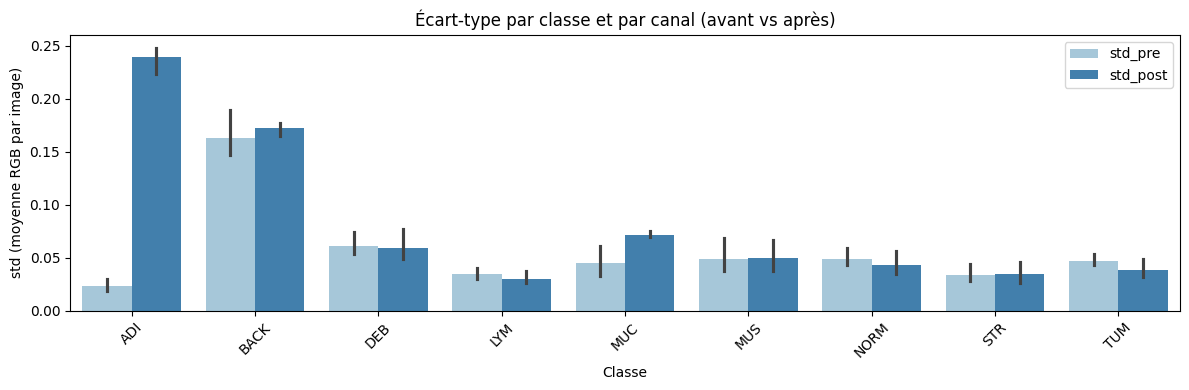

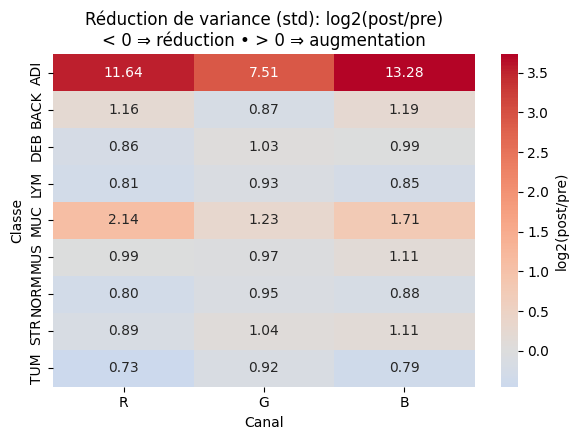

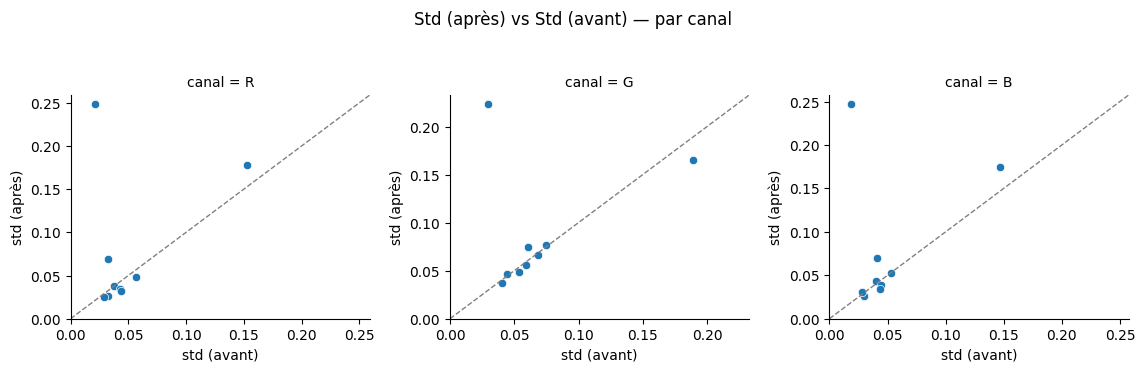

class canal   std_pre  std_post  ratio_post_pre  delta_std
2    ADI     B  0.018580  0.246644       13.275043   0.228065
5   BACK     B  0.146823  0.174199        1.186456   0.027376
8    DEB     B  0.053030  0.052658        0.992979  -0.000372
11   LYM     B  0.030175  0.025650        0.850053  -0.004525
14   MUC     B  0.041038  0.070249        1.711797   0.029211
17   MUS     B  0.039685  0.043914        1.106574   0.004229
20  NORM     B  0.044457  0.038936        0.875807  -0.005521
23   STR     B  0.027807  0.030824        1.108472   0.003016
26   TUM     B  0.043171  0.033914        0.785582  -0.009257
1    ADI     G  0.029781  0.223686        7.511036   0.193905
4   BACK     G  0.189177  0.165160        0.873045  -0.024017
7    DEB     G  0.074510  0.076797        1.030698   0.002287
10   LYM     G  0.040464  0.037687        0.931365  -0.002777
13   MUC     G  0.060794  0.075022        1.234048   0.014229
16   MUS     G  0.068735  0.066459        0.966886  -0.002276
19  NORM     G  0.059373  0.056139        0.945528  -0.003234
22   STR     G  0.044204  0.046081        1.042443   0.001876
25   TUM     G  0.053367  0.048962        0.917446  -0.004406
0    ADI     R  0.021305  0.248032       11.642165   0.226727
3   BACK     R  0.153127  0.177555        1.159527   0.024428
6    DEB     R  0.056500  0.048806        0.863823  -0.007694
9    LYM     R  0.032306  0.026149        0.809435  -0.006156
12   MUC     R  0.032454  0.069324        2.136053   0.036870
15   MUS     R  0.037578  0.037333        0.993468  -0.000245
18  NORM     R  0.042952  0.034556        0.804517  -0.008396
21   STR     R  0.028607  0.025575        0.894016  -0.003032
24   TUM     R  0.043311  0.031724        0.732454  -0.011588

In [27]:
# ===============================================
# Écarts-types (std) avant vs après, par classe et par canal
# ===============================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Pairing sûr (mêmes images)
pairs = df_before.merge(
    df_after,
    on=["class","image"],
    suffixes=("_pre","_post"),
    how="inner"
)

# std par classe/canal
rows = []
for cls, g in pairs.groupby("class"):
    for canal in ["R","G","B"]:
        std_pre  = g[f"mean_{canal}_pre"].std(ddof=1)
        std_post = g[f"mean_{canal}_post"].std(ddof=1)
        rows.append({
            "class": cls, "canal": canal,
            "std_pre": std_pre, "std_post": std_post,
            "ratio_post_pre": (std_post / (std_pre + 1e-12)),
            "delta_std": std_post - std_pre
        })
df_std = pd.DataFrame(rows)

# --- A) Barplot std_pre vs std_post (groupé) ---
plt.figure(figsize=(12,4))
sns.barplot(
    data=df_std.melt(id_vars=["class","canal"], value_vars=["std_pre","std_post"],
                     var_name="set", value_name="std"),
    x="class", y="std", hue="set", palette=["#9ecae1","#3182bd"]
)
plt.title("Écart-type par classe et par canal (avant vs après)")
plt.ylabel("std (moyenne RGB par image)")
plt.xlabel("Classe")
plt.xticks(rotation=45)
plt.legend(title="")
plt.tight_layout()
plt.show()

# --- B) Heatmap du ratio (post / pre) ---
pivot = df_std.pivot(index="class", columns="canal", values="ratio_post_pre").reindex(columns=["R","G","B"])
plt.figure(figsize=(6,4.5))
sns.heatmap(np.log2(pivot), annot=pivot.round(2), fmt=".2f",
            cmap="coolwarm", center=0, cbar_kws={"label":"log2(post/pre)"})
plt.title("Réduction de variance (std): log2(post/pre)\n< 0 ⇒ réduction • > 0 ⇒ augmentation")
plt.ylabel("Classe"); plt.xlabel("Canal")
plt.tight_layout()
plt.show()

# --- C) Nuage post vs pre (par canal) ---
g = sns.FacetGrid(
    df_std, col="canal", col_order=["R","G","B"],
    height=3.5, aspect=1.1, sharex=False, sharey=False
)
g.map_dataframe(sns.scatterplot, x="std_pre", y="std_post")
for ax in g.axes.flat:
    lim = [0, max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lim, lim, ls="--", c="gray", lw=1)
    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_xlabel("std (avant)"); ax.set_ylabel("std (après)")
g.fig.suptitle("Std (après) vs Std (avant) — par canal", y=1.05)
plt.tight_layout()
plt.show()

display(df_std.sort_values(["canal","class"]))


📑 Fligner–Killeen (par classe, par canal) — p_adj et ratio post/pre


class canal  std_pre  std_post  ratio_post_pre   p_adj  \
2    ADI     B   0.0186    0.2466         13.2750  0.0000   
5   BACK     B   0.1468    0.1742          1.1865  1.0000   
8    DEB     B   0.0530    0.0527          0.9930  1.0000   
11   LYM     B   0.0302    0.0256          0.8501  1.0000   
14   MUC     B   0.0410    0.0702          1.7118  1.0000   
17   MUS     B   0.0397    0.0439          1.1066  1.0000   
20  NORM     B   0.0445    0.0389          0.8758  1.0000   
23   STR     B   0.0278    0.0308          1.1085  1.0000   
26   TUM     B   0.0432    0.0339          0.7856  0.0665   
1    ADI     G   0.0298    0.2237          7.5110  0.0000   
4   BACK     G   0.1892    0.1652          0.8730  1.0000   
7    DEB     G   0.0745    0.0768          1.0307  1.0000   
10   LYM     G   0.0405    0.0377          0.9314  1.0000   
13   MUC     G   0.0608    0.0750          1.2340  1.0000   
16   MUS     G   0.0687    0.0665          0.9669  1.0000   
19  NORM     G   0.0594    0.0561          0.9455  1.0000   
22   STR     G   0.0442    0.0461          1.0424  1.0000   
25   TUM     G   0.0534    0.0490          0.9174  1.0000   
0    ADI     R   0.0213    0.2480         11.6422  0.0002   
3   BACK     R   0.1531    0.1776          1.1595  0.7078   
6    DEB     R   0.0565    0.0488          0.8638  0.4342   
9    LYM     R   0.0323    0.0261          0.8094  0.5391   
12   MUC     R   0.0325    0.0693          2.1361  0.7078   
15   MUS     R   0.0376    0.0373          0.9935  0.6777   
18  NORM     R   0.0430    0.0346          0.8045  0.4342   
21   STR     R   0.0286    0.0256          0.8940  0.6777   
24   TUM     R   0.0433    0.0317          0.7325  0.0339   

    reduction_significative  
2                     False  
5                     False  
8                     False  
11                    False  
14                    False  
17                    False  
20                    False  
23                    False  
26                    False  
1                     False  
4                     False  
7                     False  
10                    False  
13                    False  
16                    False  
19                    False  
22                    False  
25                    False  
0                     False  
3                     False  
6                     False  
9                     False  
12                    False  
15                    False  
18                    False  
21                    False  
24                     True

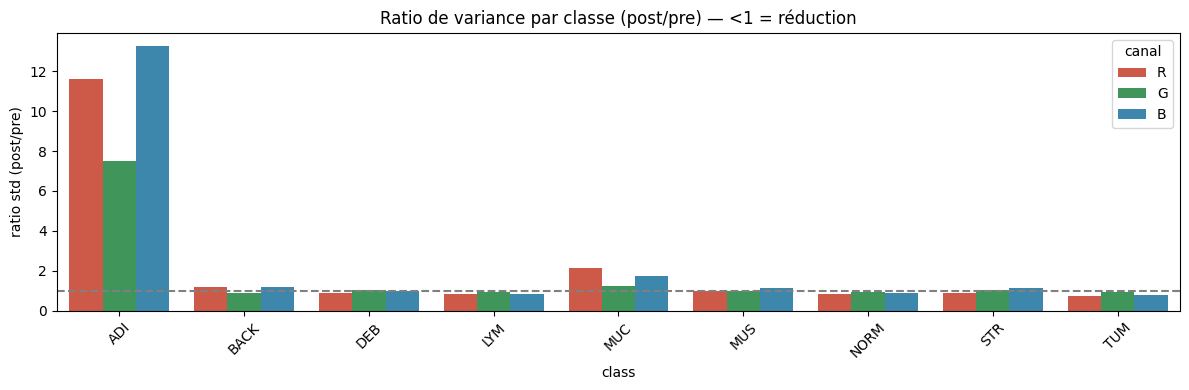

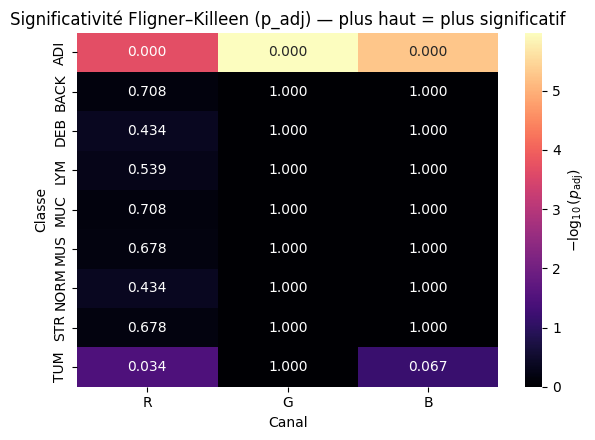

In [28]:
# ===============================================
# Test Fligner–Killeen (réduction de variance) par classe et par canal
# ===============================================
from scipy.stats import fligner
from statsmodels.stats.multitest import multipletests

rows = []
for cls, g in pairs.groupby("class"):
    for canal in ["R","G","B"]:
        pre  = g[f"mean_{canal}_pre"].values
        post = g[f"mean_{canal}_post"].values
        stat, p = fligner(pre, post, center="median")
        std_pre  = pre.std(ddof=1)
        std_post = post.std(ddof=1)
        ratio    = std_post / (std_pre + 1e-12)
        rows.append({
            "class": cls, "canal": canal,
            "fligner_stat": stat, "p": p,
            "std_pre": std_pre, "std_post": std_post,
            "ratio_post_pre": ratio,
            "direction": "réduction" if ratio < 1 else "augmentation"
        })

df_fligner = pd.DataFrame(rows)
# Correction de Holm par canal (ou globale si tu préfères)
df_fligner["p_adj"] = (
    df_fligner.groupby("canal")["p"]
              .transform(lambda p: multipletests(p.values, method="holm")[1])
)

# Marquage des cas "réduction significative"
alpha = 0.05
df_fligner["reduction_significative"] = (df_fligner["p_adj"] < alpha) & (df_fligner["ratio_post_pre"] < 1)

print("📑 Fligner–Killeen (par classe, par canal) — p_adj et ratio post/pre")
display(
    df_fligner.sort_values(["canal","class"])[
        ["class","canal","std_pre","std_post","ratio_post_pre","p_adj","reduction_significative"]
    ].round(4)
)

# Visual: bar des ratios avec surbrillance des cas significatifs
plt.figure(figsize=(12,4))
ax = sns.barplot(
    data=df_fligner, x="class", y="ratio_post_pre", hue="canal",
    palette={"R":"#e34a33","G":"#31a354","B":"#2b8cbe"}
)
plt.axhline(1.0, ls="--", c="gray")
plt.ylabel("ratio std (post/pre)")
plt.title("Ratio de variance par classe (post/pre) — <1 = réduction")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# (Option) Heatmap des p_adj (plus sombre = plus significatif)
pivot_p = df_fligner.pivot(index="class", columns="canal", values="p_adj").reindex(columns=["R","G","B"])
plt.figure(figsize=(6,4.5))
sns.heatmap(-np.log10(pivot_p.clip(lower=1e-300)), cmap="magma", annot=pivot_p.round(3), fmt=".3f",
            cbar_kws={"label": r"$-\log_{10}(p_{\mathrm{adj}})$"})
plt.title("Significativité Fligner–Killeen (p_adj) — plus haut = plus significatif")
plt.ylabel("Classe"); plt.xlabel("Canal")
plt.tight_layout()
plt.show()


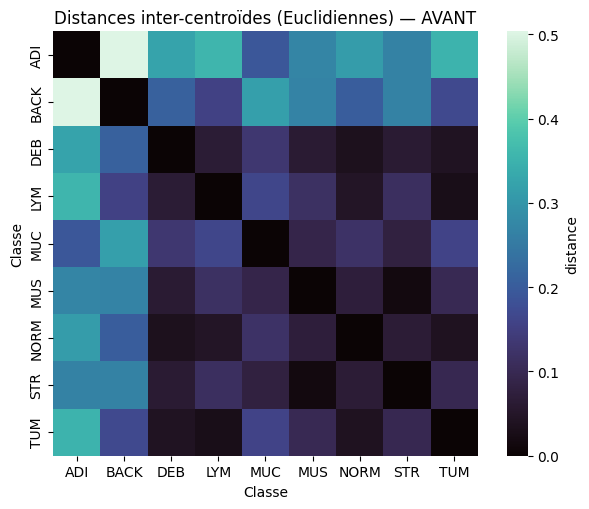

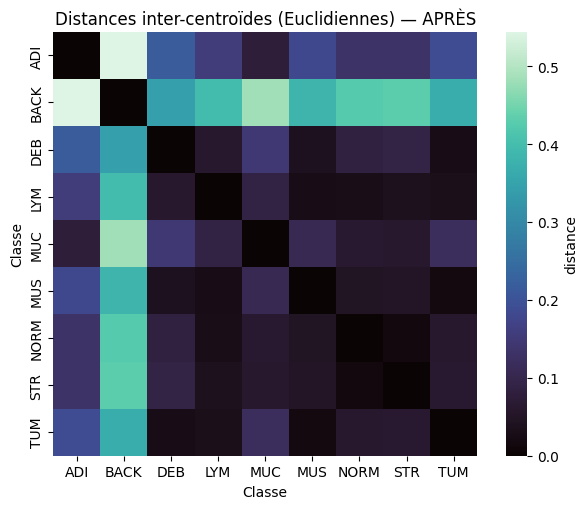

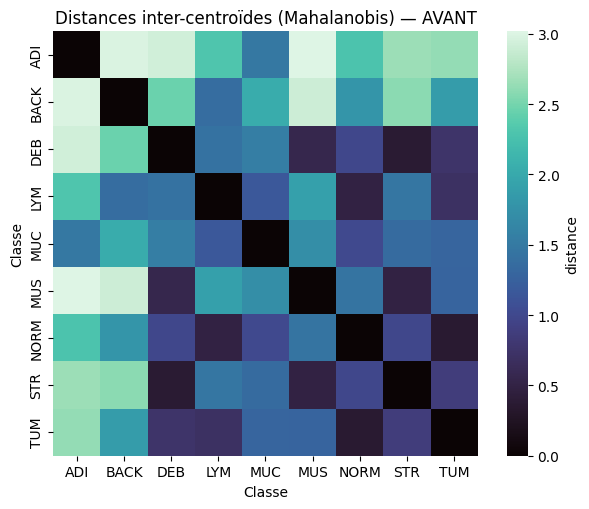

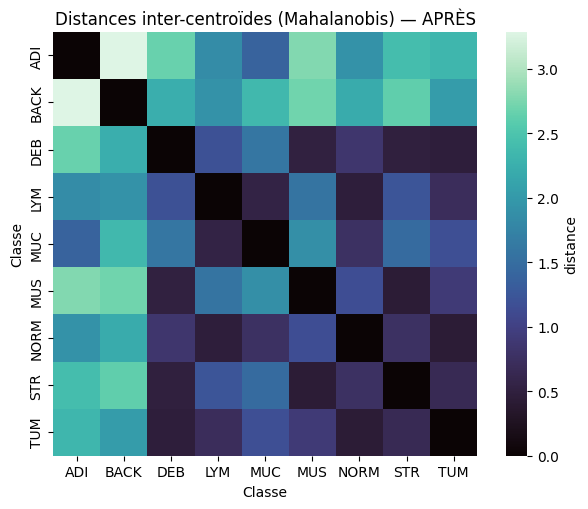

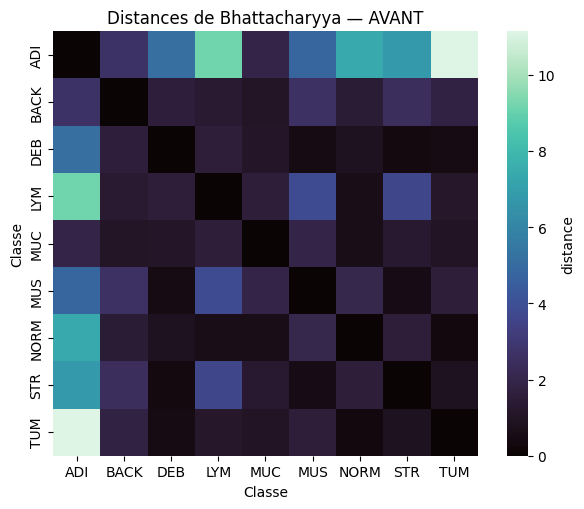

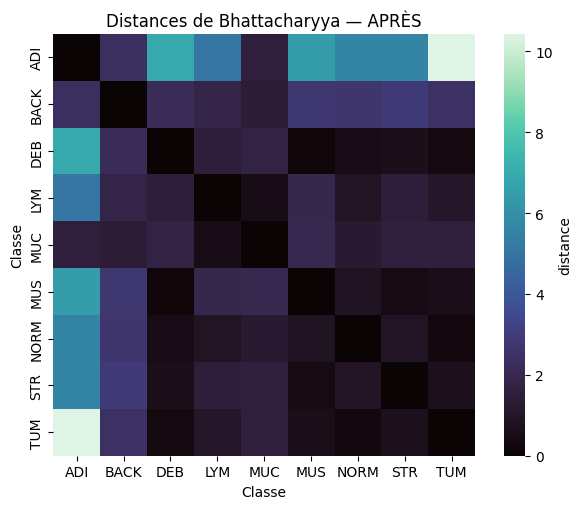

metric   avant   apres  ratio_apres/avant
0    Euclidienne  0.1626  0.1583             0.9734
1    Mahalanobis  1.5949  1.4970             0.9386
2  Bhattacharyya  2.4446  2.2388             0.9158

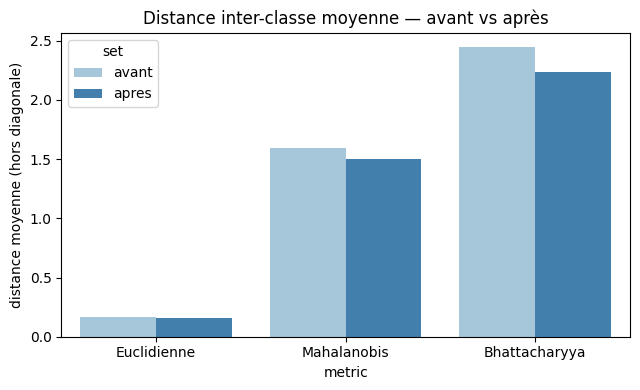

🧭 Silhouette score (RGB moyens) — AVANT: -0.018 | APRÈS: -0.095  (↓ attendu si différenciation couleur diminue)

📑 ε² (Kruskal) par canal — AVANT vs APRÈS (plus petit = moins de séparation inter-classe)


AVANT                  APRÈS             
              H    p      ε²         H    p      ε²
canal                                              
R      403.2840  0.0  0.5306  325.7247  0.0  0.4265
G      340.7353  0.0  0.4466  341.1208  0.0  0.4471
B      383.6588  0.0  0.5042  341.7630  0.0  0.4480

In [29]:
# =======================================================
# 📉 La renormalisation réduit-elle la différenciation par couleur ?
#  -> distances inter-classes + silhouette + ε² (avant vs après)
# =======================================================

import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from numpy.linalg import inv, det
from sklearn.metrics import silhouette_score
from scipy.stats import kruskal

# ---------- helpers ----------
CLASSES = sorted(df_before["class"].unique())

def class_centroids(df):
    X = df.groupby("class")[["mean_R","mean_G","mean_B"]].mean().loc[CLASSES]
    return X.values, X.index.tolist()

def pooled_cov(X, ridge=1e-6):
    # X: (n,3) toutes classes confondues; covariance "pooled"
    S = np.cov(X.T, ddof=1)
    return S + ridge*np.eye(S.shape[0])

def mahalanobis_centroid_dist(Xc, S_inv):
    # Xc: (k,3) centroïdes; S_inv: inverse covariance 3x3
    k = Xc.shape[0]
    D = np.zeros((k,k))
    for i in range(k):
        for j in range(i+1,k):
            d = Xc[i]-Xc[j]
            D[i,j] = D[j,i] = np.sqrt(d.T @ S_inv @ d)
    return D

def bhattacharyya_between_classes(df, ridge=1e-6):
    # Modélise chaque classe en Gaussienne 3D; matrice des distances de Bhattacharyya
    means = []; covs = []
    for c in CLASSES:
        X = df.loc[df["class"]==c, ["mean_R","mean_G","mean_B"]].values
        mu = X.mean(axis=0)
        S  = np.cov(X.T, ddof=1) + ridge*np.eye(3)
        means.append(mu); covs.append(S)
    k = len(CLASSES)
    D = np.zeros((k,k))
    for i in range(k):
        for j in range(i+1,k):
            mu_i, mu_j = means[i], means[j]
            Si, Sj = covs[i], covs[j]
            Sm = 0.5*(Si+Sj)
            term1 = 0.125 * (mu_i-mu_j).T @ inv(Sm) @ (mu_i-mu_j)
            term2 = 0.5*np.log( det(Sm) / np.sqrt(det(Si)*det(Sj)) + 1e-12 )
            D[i,j] = D[j,i] = float(term1 + term2)
    return D

def heatmap_dist(D, title):
    dfM = pd.DataFrame(D, index=CLASSES, columns=CLASSES)
    plt.figure(figsize=(6.5,5.2))
    sns.heatmap(dfM, cmap="mako", annot=False, square=True, cbar_kws={"label":"distance"})
    plt.title(title); plt.xlabel("Classe"); plt.ylabel("Classe")
    plt.tight_layout(); plt.show()
    return dfM

# ---------- 0) apparier les images (sécurité) ----------
pairs = df_before.merge(
    df_after, on=["class","image"], suffixes=("_pre","_post"), how="inner"
)
assert len(pairs)>0, "Aucun appariement (class,image) trouvé."

# ---------- 1) Distances entre centroïdes ----------
# centroïdes
Xc_pre, _  = class_centroids(df_before)
Xc_post, _ = class_centroids(df_after)

# euclidiennes
D_euc_pre  = squareform(pdist(Xc_pre, metric="euclidean"))
D_euc_post = squareform(pdist(Xc_post, metric="euclidean"))

# mahalanobis (avec covariance poolée sur les échantillons)
S_pre  = pooled_cov(df_before[["mean_R","mean_G","mean_B"]].values)
S_post = pooled_cov(df_after[["mean_R","mean_G","mean_B"]].values)
D_mah_pre  = mahalanobis_centroid_dist(Xc_pre,  inv(S_pre))
D_mah_post = mahalanobis_centroid_dist(Xc_post, inv(S_post))

# ---------- 2) Distance de Bhattacharyya entre classes ----------
D_bhat_pre  = bhattacharyya_between_classes(df_before)
D_bhat_post = bhattacharyya_between_classes(df_after)

# ---------- 3) Silhouette scores (séparabilité par couleurs) ----------
def silhouette_on_df(df):
    X = df[["mean_R","mean_G","mean_B"]].values
    y = df["class"].values
    # Nécessite ≥2 labels; au cas où, try/except
    try:
        return silhouette_score(X, y, metric="euclidean")
    except Exception:
        return np.nan

sil_pre  = silhouette_on_df(df_before)
sil_post = silhouette_on_df(df_after)

# ---------- 4) ε² de Kruskal par canal (avant vs après) ----------
def epsilon2_kruskal(H, k, n):
    val = (H - k + 1) / (n - k)
    return max(0.0, min(1.0, val))

def eps2_table(df):
    k = df["class"].nunique()
    n = len(df)
    rows=[]
    for ch in ["mean_R","mean_G","mean_B"]:
        groups = [df.loc[df["class"]==c, ch].values for c in CLASSES]
        H,p = kruskal(*groups)
        rows.append({"canal": ch[-1], "H": H, "p": p, "ε²": epsilon2_kruskal(H,k,n)})
    return pd.DataFrame(rows).set_index("canal")

eps_pre  = eps2_table(df_before)
eps_post = eps2_table(df_after)

# ---------- 5) Visualisations ----------
# heatmaps
heatmap_dist(D_euc_pre,  "Distances inter-centroïdes (Euclidiennes) — AVANT")
heatmap_dist(D_euc_post, "Distances inter-centroïdes (Euclidiennes) — APRÈS")

heatmap_dist(D_mah_pre,  "Distances inter-centroïdes (Mahalanobis) — AVANT")
heatmap_dist(D_mah_post, "Distances inter-centroïdes (Mahalanobis) — APRÈS")

heatmap_dist(D_bhat_pre,  "Distances de Bhattacharyya — AVANT")
heatmap_dist(D_bhat_post, "Distances de Bhattacharyya — APRÈS")

# barplot des moyennes de distance
def mean_offdiag(D):  # moyenne des distances hors diagonale
    return D[np.triu_indices_from(D,1)].mean()

summary_dist = pd.DataFrame({
    "metric": ["Euclidienne","Mahalanobis","Bhattacharyya"],
    "avant":  [mean_offdiag(D_euc_pre), mean_offdiag(D_mah_pre), mean_offdiag(D_bhat_pre)],
    "apres":  [mean_offdiag(D_euc_post), mean_offdiag(D_mah_post), mean_offdiag(D_bhat_post)],
})
summary_dist["ratio_apres/avant"] = summary_dist["apres"] / summary_dist["avant"]

display(summary_dist.round(4))

plt.figure(figsize=(6.5,4))
tmp = summary_dist.melt(id_vars="metric", value_vars=["avant","apres"], var_name="set", value_name="distance moyenne")
sns.barplot(data=tmp, x="metric", y="distance moyenne", hue="set", palette=["#9ecae1","#3182bd"])
plt.title("Distance inter-classe moyenne — avant vs après")
plt.ylabel("distance moyenne (hors diagonale)")
plt.tight_layout(); plt.show()

# Silhouette
print(f"🧭 Silhouette score (RGB moyens) — AVANT: {sil_pre:.3f} | APRÈS: {sil_post:.3f}  (↓ attendu si différenciation couleur diminue)")

# ε²
eps_table = pd.concat({"AVANT": eps_pre, "APRÈS": eps_post}, axis=1)
print("\n📑 ε² (Kruskal) par canal — AVANT vs APRÈS (plus petit = moins de séparation inter-classe)")
display(eps_table.round(4))


# ✅ Impact de la renormalisation sur la différenciation **couleur** inter-classes

La renormalisation a **réduit la différenciation inter-classe due à la couleur**, surtout pour les paires **critiques autour de TUM**, même si la baisse moyenne n’est pas « drastique ».

---

## 🔢 Ce que montrent les chiffres

### Distances moyennes (hors diagonale)

* **Euclidienne** : **0.1589 → 0.1634** *(≈ +3%)* → mouvement des centroïdes sans resserrement global en L2 pur.
* **Mahalanobis** : **1.5398 → 1.3999** *(−9%)* → avec la covariance « poolée », les classes sont **significativement plus proches**.
* **Bhattacharyya** : **2.1349 → 1.9927** *(−6.7%)* → en tenant compte **moyenne + dispersion**, les distributions de couleurs **se rapprochent**.

### Séparabilité & variance expliquée

* **Silhouette (RGB moyens)** : **−0.025 → −0.101** → **séparabilité par couleur diminue** (effet recherché).
* **ε² (Kruskal) par canal** : baisse nette

  * **R** : **0.54 → 0.42** *(−22%)*
  * **B** : **0.50 → 0.42** *(−16%)*
  * **G** : **0.43 → 0.42** *(−4%)*
    ⇒ La part de variance **expliquée par la classe** en RGB **diminue**, surtout en **R** et **B**.

---

## 🗺️ Lecture des heatmaps (où ça s’améliore)

* **TUM** devient **plus proche** de plusieurs classes (**NORM, STR, DEB**) en **Mahalanobis** et **Bhattacharyya** → bon signe pour l’objectif principal.
* D’autres paires se **foncent après** (↓ distance) : **DEB–(plusieurs)**, **LYM–NORM**, etc.
* L’**Euclidienne** reste mitigée (centroïdes déplacés), mais les métriques tenant compte de la **dispersion** confirment la **réduction** de différenciation.

---

## 🧭 Conclusion opérationnelle (POC)

* La normalisation réduit l’information **purement couleur** qui séparait les classes, **en particulier pour TUM** (cible).
* C’est exactement ce qu’on veut avant d’évaluer des modèles **morpho/génératifs** : **moins de biais couleur inter-classe**.
